In [ ]:
!pip install fvcore
from fvcore.nn import FlopCountAnalysis

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 478kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.66MB/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw


Optimized Modification 6:
  Params: 1,183,166
  FLOPs: 152,461,312
  Runtime: 4.77 ms
  Accuracy: 0.1100
  F1 Score: 0.0506
  Precision: 0.0388
  Recall: 0.1000

Optimized Modification 7:
  Params: 1,183,260
  FLOPs: 75,579,392
  Runtime: 61.60 ms
  Accuracy: 0.1100
  F1 Score: 0.0506
  Precision: 0.0388
  Recall: 0.1000


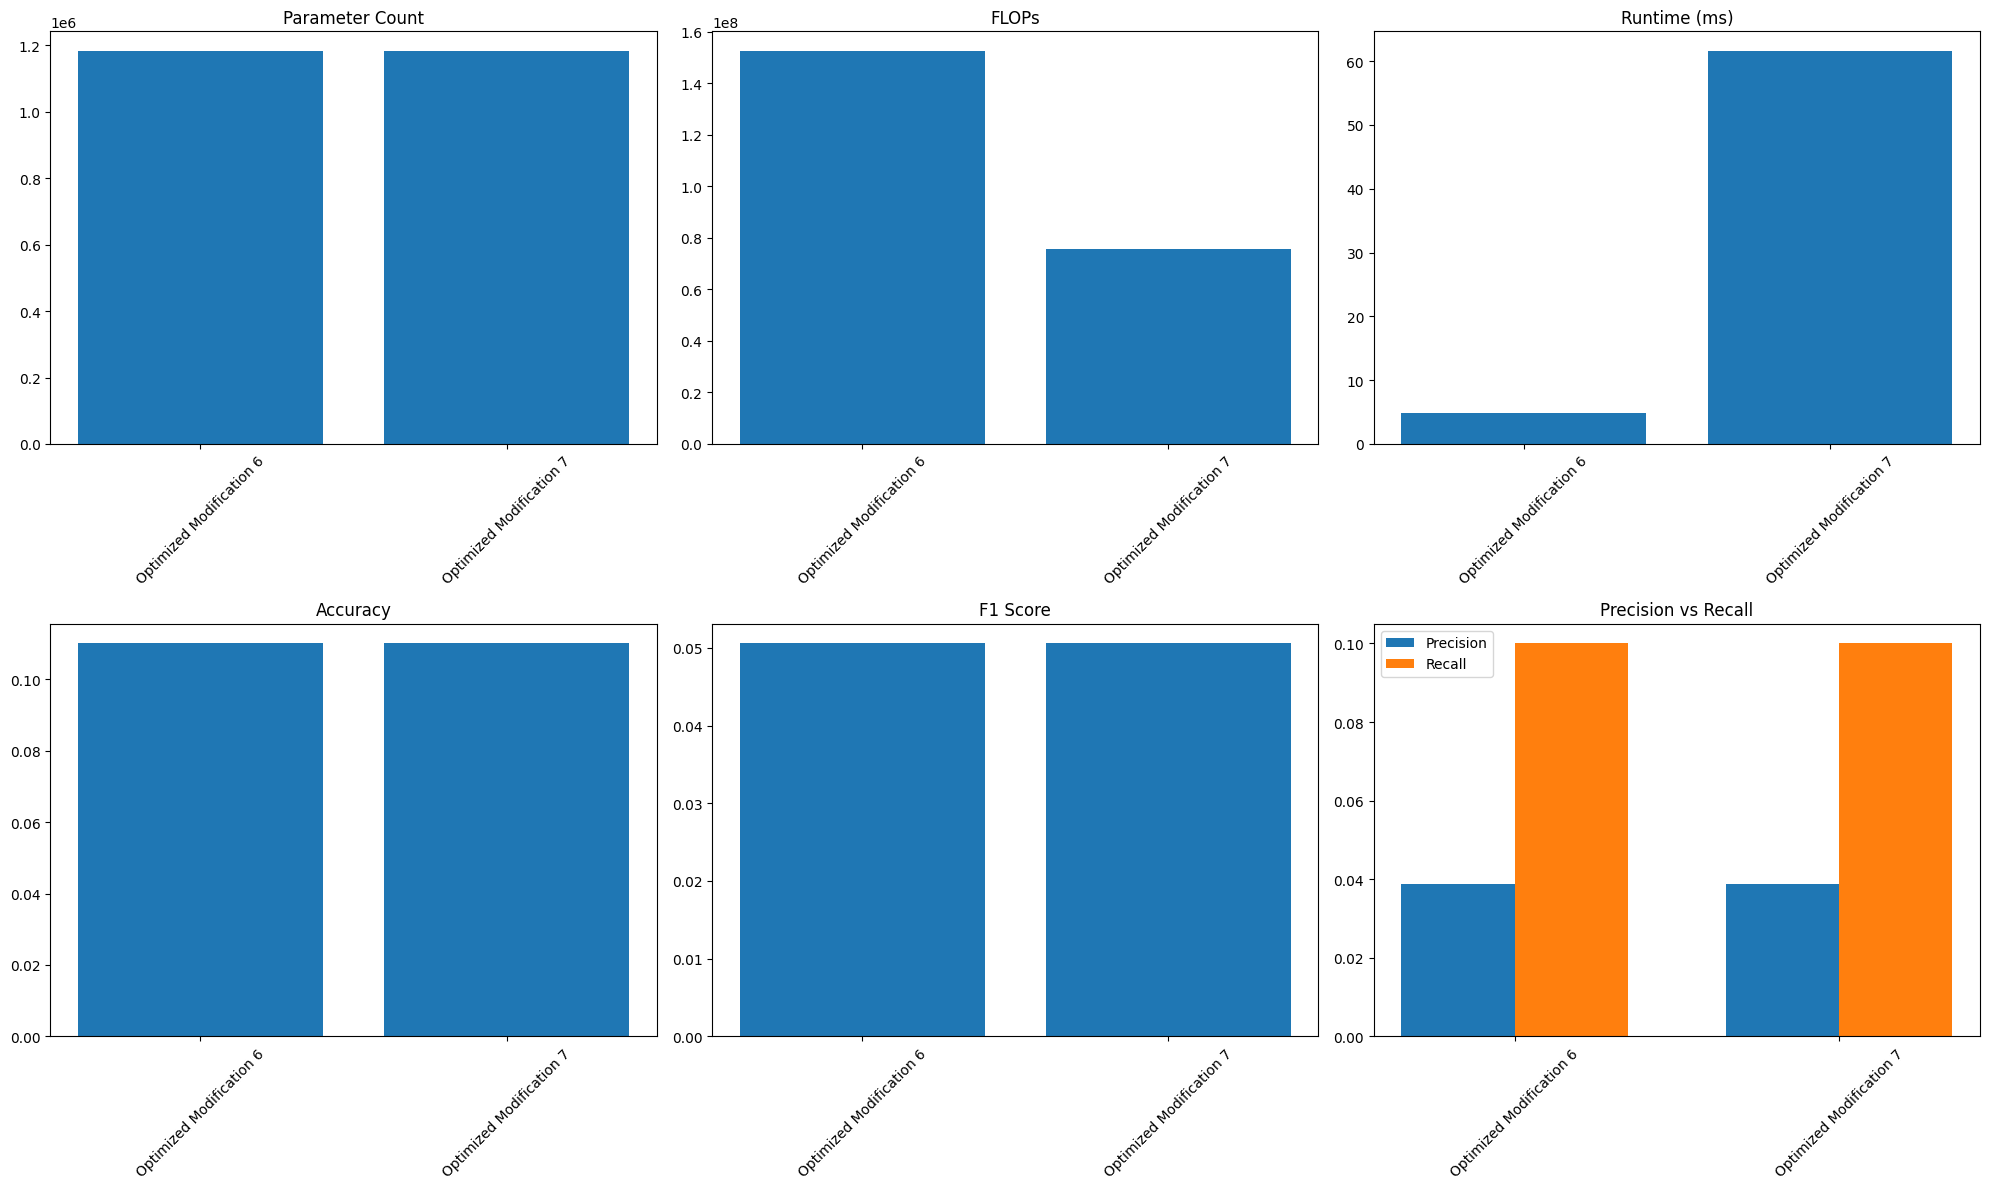

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import numpy as np
from torch.profiler import profile, record_function, ProfilerActivity
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# ===== Configuration =====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
SUBSET_SIZE = 100  # For quick testing
SEED = 42
torch.manual_seed(SEED)

# ===== Data Loading =====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load full dataset for evaluation
full_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
full_test = datasets.MNIST('../data', train=False, transform=transform)

# Create small subset for profiling
train_subset = Subset(full_train, indices=range(SUBSET_SIZE))
test_subset = Subset(full_test, indices=range(SUBSET_SIZE))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=BATCH_SIZE)


# Modification 6: On Mod-4 for accepting stride and padding to match the actual Conv2d calls
class SamePadOptimizedInertialConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 threshold_init=0.1,
                 scale_init=10.0):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Core 1×1 kernel
        self.core = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))
        
        # Learnable threshold & scale
        self.threshold = nn.Parameter(torch.tensor([threshold_init]))
        self.scale = nn.Parameter(torch.tensor([scale_init]))
        
        # Shared periphery weights (8 neighbors)
        self.periphery = nn.Parameter(torch.Tensor(8))
        nn.init.kaiming_uniform_(self.core)
        nn.init.uniform_(self.periphery, -0.1, 0.1)

    def forward(self, x):
        B, C, H, W = x.shape

        # 1) extract 3×3 patches with given stride & padding
        patches = F.unfold(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )                                      # (B, C*9, L)
        _, _, L = patches.shape
        patches = patches.view(B, C, 9, L)     # (B, C, 9, L)

        # compute output spatial dims
        H_out = (H + 2*self.padding - self.kernel_size) // self.stride + 1
        W_out = (W + 2*self.padding - self.kernel_size) // self.stride + 1

        # 2) divergence on center vs periphery
        center = patches[:, :, 4, :].unsqueeze(2)    # (B, C, 1, L)
        diffs  = (patches - center) ** 2
        div    = diffs.sum(dim=(1,2)).view(B, H_out, W_out)

        # 3) STE mask
        m_soft = torch.sigmoid((div - self.threshold) * self.scale).unsqueeze(1)
        m_hard = (m_soft > 0.5).float()
        # mask   = m_hard.detach() - m_soft.detach() + m_soft
        mask = m_hard + m_soft - m_soft.detach()

        # 4) allocate output
        out = torch.zeros(B, self.out_channels, H_out, W_out, device=x.device)

        # 5) core-only where mask==0
        zeros = torch.where(m_hard.view(B, -1) == 0)
        if zeros[0].numel():
            b_idx, pos = zeros
            cen = center.squeeze(2)                   # (B, C, L)
            vals = cen[b_idx, :, pos]                # (N0, C)
            w   = self.core.view(self.out_channels, self.in_channels)  # (OC, C)
            out.view(B, self.out_channels, -1)[b_idx, :, pos] = vals @ w.t()

        # 6) detailed where mask==1
        ones = torch.where(m_hard.view(B, -1) == 1)
        if ones[0].numel():
            b_idx, pos = ones
            flat = patches.permute(0,3,1,2).reshape(-1, C, 9)  # (B*L, C, 9)
            sel  = flat[b_idx * L + pos]                       # (Nd, C, 9)
            peri = sel[:, :, [0,1,2,3,5,6,7,8]]               # (Nd, C, 8)
            w    = peri * self.periphery.view(1,1,8)         # (Nd, C, 8)
            agg  = w.sum(dim=2)                              # (Nd, C)
            w1   = self.core.view(self.out_channels, self.in_channels)
            out.view(B, self.out_channels, -1)[b_idx, :, pos] = agg @ w1.t()

        return out

# Modification 7
class ChannelThresOptimizedInertialConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 threshold_init=0.1,
                 scale_init=10.0):
        super().__init__()
        assert kernel_size == 3, "Kernel size must be 3x3"
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.kernel_size  = kernel_size
        self.stride       = stride
        self.padding      = padding

        # 1×1 core
        self.core      = nn.Parameter(torch.Tensor(out_channels, in_channels, 1, 1))
        # one threshold per output channel
        self.threshold = nn.Parameter(torch.ones(out_channels) * threshold_init)
        # global scale
        self.scale     = nn.Parameter(torch.tensor([scale_init]))
        # 8 shared periphery weights
        self.periphery = nn.Parameter(torch.Tensor(8))

        nn.init.kaiming_uniform_(self.core)
        nn.init.uniform_(self.periphery, -0.1, 0.1)

    def forward(self, x):
        B, C, H, W = x.shape
        # unfold -> (B, C*9, L)
        patches = F.unfold(
            x,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )
        _, _, L = patches.shape
        # reshape -> (B, C, 9, L)
        patches = patches.view(B, C, 9, L)

        # output spatial dims
        H_out = (H + 2*self.padding - self.kernel_size)//self.stride + 1
        W_out = (W + 2*self.padding - self.kernel_size)//self.stride + 1

        # divergence: center vs periphery
        center = patches[:, :, 4, :].unsqueeze(2)            # (B, C, 1, L)
        diffs  = (patches - center)**2
        div    = diffs.sum(dim=(1,2)).view(B, H_out, W_out)   # (B, H_out, W_out)

        # per-channel STE mask
        t = self.threshold.view(1, self.out_channels, 1, 1)
        m_soft = torch.sigmoid((div.unsqueeze(1) - t) * self.scale)
        m_hard = (m_soft > 0.5).float()
        mask   = m_hard.detach() - m_soft.detach() + m_soft  # (B, OC, H_out, W_out)

        # prepare output
        out      = x.new_zeros(B, self.out_channels, H_out, W_out)
        out_flat = out.view(B, self.out_channels, -1)        # (B, OC, L)
        mask_flat= m_hard.view(B, self.out_channels, -1)     # (B, OC, L)
        cen_flat = center.squeeze(2)                         # (B, C, L)

        # 1) core branch where mask==0
        b0, oc0, p0 = torch.where(mask_flat == 0)
        if b0.numel():
            vals   = cen_flat[b0, :, p0]                     # (N0, C)
            w_core = self.core.view(self.out_channels, C)[oc0]  # (N0, C)
            core_o = (vals * w_core).sum(dim=1)              # (N0,)
            out_flat[b0, oc0, p0] = core_o

        # 2) detailed branch where mask==1
        b1, oc1, p1 = torch.where(mask_flat == 1)
        if b1.numel():
            flat_p = patches.permute(0,3,1,2).reshape(-1, C, 9)  # (B*L, C, 9)
            idx    = b1 * L + p1
            sel    = flat_p[idx]                                 # (N1, C, 9)
            peri   = sel[:, :, [0,1,2,3,5,6,7,8]]                 # (N1, C, 8)
            w8     = peri * self.periphery.view(1,1,8)           # (N1, C, 8)
            agg    = w8.sum(dim=2)                               # (N1, C)
            w1     = self.core.view(self.out_channels, C)[oc1]   # (N1, C)
            det_o  = (agg * w1).sum(dim=1)                       # (N1,)
            out_flat[b1, oc1, p1] = det_o

        return out

# ===== Evaluation Metrics =====
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



# ===== Enhanced Benchmarking Function =====
def benchmark_model(model_class, name):
    torch.manual_seed(SEED)
    model = model_class().to(DEVICE)
    
    # 1. Parameter counting
    total_params = sum(p.numel() for p in model.parameters())
    
    # 2. FLOPs calculation using fvcore
    flops = 0
    for data, _ in train_loader:
        inputs = data.to(DEVICE)
        flops = FlopCountAnalysis(model, inputs).total()
        break
    
    # 3. Runtime profiling
    runtime_ms = 0
    if "cuda" in DEVICE:
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        repetitions = 30
        timings = []
        
        # Warm-up
        for _ in range(10):
            _ = model(data.to(DEVICE))
        
        # Measure
        with torch.no_grad():
            for rep in range(repetitions):
                starter.record()
                _ = model(data.to(DEVICE))
                ender.record()
                torch.cuda.synchronize()
                timings.append(starter.elapsed_time(ender))
        
        runtime_ms = sum(timings) / repetitions
    else:
        import time
        repetitions = 30
        timings = []
        
        # Warm-up
        for _ in range(10):
            _ = model(data.to(DEVICE))
        
        # Measure
        with torch.no_grad():
            for rep in range(repetitions):
                start = time.time()
                _ = model(data.to(DEVICE))
                end = time.time()
                timings.append((end - start) * 1000)  # Convert to ms
        
        runtime_ms = sum(timings) / repetitions
    
    # 4. Performance metrics
    metrics = evaluate_model(model, test_loader)
    
    print(f"\n{name}:")
    print(f"  Params: {total_params:,}")
    print(f"  FLOPs: {flops:,}")
    print(f"  Runtime: {runtime_ms:.2f} ms")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    
    return {
        "name": name,
        "params": total_params,
        "flops": flops,
        "runtime": runtime_ms,
        "accuracy": metrics['accuracy'],
        "f1": metrics['f1'],
        "precision": metrics['precision'],
        "recall": metrics['recall']
    }



# ===== Run Benchmarks =====
results = []

# Optimization 6
class SamePadOptimizedInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SamePadOptimizedInertialConv2d(1, 32, 3, 1, 0)
        self.conv2 = SamePadOptimizedInertialConv2d(32, 64, 3, 1, 0)
        self.fc1   = nn.Linear(9216, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(SamePadOptimizedInertialNet,"Optimized Modification 6"))

# Optimization 7
class ChannelThresOptimizedInertialNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ChannelThresOptimizedInertialConv2d(1, 32, 3, 1, 0)
        self.conv2 = ChannelThresOptimizedInertialConv2d(32,64, 3, 1, 0)
        self.fc1   = nn.Linear(9216, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
results.append(benchmark_model(ChannelThresOptimizedInertialNet,"Optimized Modification 7"))



# ===== Enhanced Visualization =====
fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# Parameter Count
axs[0,0].bar([r["name"] for r in results], [r["params"] for r in results])
axs[0,0].set_title("Parameter Count")
axs[0,0].tick_params(axis='x', rotation=45)

# FLOPs (only show if available)
if any(r["flops"] is not None for r in results):
    axs[0,1].bar([r["name"] for r in results], [r["flops"] or 0 for r in results])
    axs[0,1].set_title("FLOPs")
    axs[0,1].tick_params(axis='x', rotation=45)
else:
    axs[0,1].axis('off')

# Runtime
axs[0,2].bar([r["name"] for r in results], [r["runtime"] for r in results])
axs[0,2].set_title("Runtime (ms)")
axs[0,2].tick_params(axis='x', rotation=45)

# Accuracy
axs[1,0].bar([r["name"] for r in results], [r["accuracy"] for r in results])
axs[1,0].set_title("Accuracy")
axs[1,0].tick_params(axis='x', rotation=45)

# F1 Score
axs[1,1].bar([r["name"] for r in results], [r["f1"] for r in results])
axs[1,1].set_title("F1 Score")
axs[1,1].tick_params(axis='x', rotation=45)

# Precision-Recall
width = 0.35
x = np.arange(len(results))
axs[1,2].bar(x - width/2, [r["precision"] for r in results], width, label='Precision')
axs[1,2].bar(x + width/2, [r["recall"] for r in results], width, label='Recall')
axs[1,2].set_title("Precision vs Recall")
axs[1,2].set_xticks(x)
axs[1,2].set_xticklabels([r["name"] for r in results], rotation=45)
axs[1,2].legend()

plt.tight_layout()
plt.savefig("benchmark_results.png", dpi=300, bbox_inches='tight')
plt.show()

FULL TRAINING ON MNIST

Epoch 1: 100%|██████████| 938/938 [00:16<00:00, 56.22it/s]


Epoch 1 completed


Epoch 2: 100%|██████████| 938/938 [00:16<00:00, 57.51it/s]


Epoch 2 completed


Epoch 3: 100%|██████████| 938/938 [00:16<00:00, 57.50it/s]


Epoch 3 completed


Epoch 4: 100%|██████████| 938/938 [00:16<00:00, 57.47it/s]


Epoch 4 completed


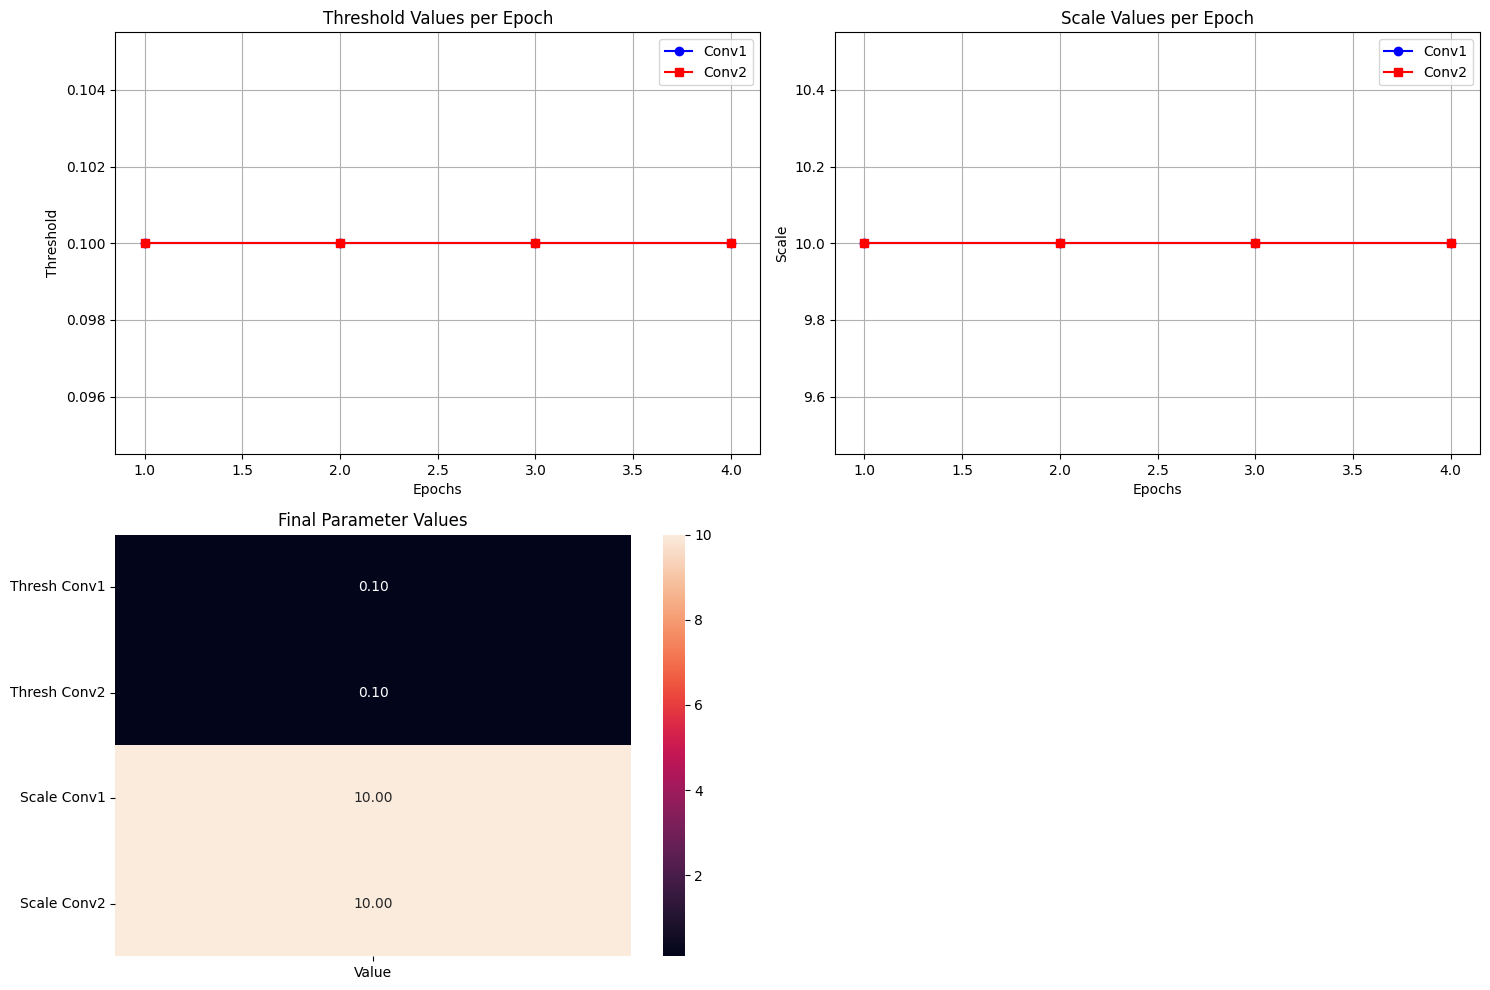

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

# Hyperparam Metrics Collection
hyperparam_metrics = {
    'threshold_conv1': [],
    'scale_conv1': [],
    'threshold_conv2': [],
    'scale_conv2': [],
    'epochs': []
}

# Modified Training Loop
def train_model(model, train_loader, test_loader, epochs=4):
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(4):
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        # Collect parameters after each epoch
        if isinstance(model, nn.DataParallel):
            conv1 = model.module.conv1
            conv2 = model.module.conv2
        else:
            conv1 = model.conv1
            conv2 = model.conv2
            
        hyperparam_metrics['threshold_conv1'].append(conv1.threshold.item())
        hyperparam_metrics['scale_conv1'].append(conv1.scale.item())
        hyperparam_metrics['threshold_conv2'].append(conv2.threshold.item())
        hyperparam_metrics['scale_conv2'].append(conv2.scale.item())
        hyperparam_metrics['epochs'].append(epoch+1)
        
        print(f'Epoch {epoch+1} completed')

# Visualization Code
def plot_metrics(hyperparam_metrics):
    plt.figure(figsize=(15, 10))
    
    # Threshold Progression
    plt.subplot(2, 2, 1)
    plt.plot(hyperparam_metrics['epochs'], hyperparam_metrics['threshold_conv1'], 'bo-')
    plt.plot(hyperparam_metrics['epochs'], hyperparam_metrics['threshold_conv2'], 'rs-')
    plt.title('Threshold Values per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Threshold')
    plt.legend(['Conv1', 'Conv2'])
    plt.grid(True)

    # Scale Progression
    plt.subplot(2, 2, 2)
    plt.plot(hyperparam_metrics['epochs'], hyperparam_metrics['scale_conv1'], 'bo-')
    plt.plot(hyperparam_metrics['epochs'], hyperparam_metrics['scale_conv2'], 'rs-')
    plt.title('Scale Values per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Scale')
    plt.legend(['Conv1', 'Conv2'])
    plt.grid(True)

    # Heatmap of Final Parameters
    plt.subplot(2, 2, 3)
    final_params = np.array([
        hyperparam_metrics['threshold_conv1'][-1:], 
        hyperparam_metrics['threshold_conv2'][-1:],
        hyperparam_metrics['scale_conv1'][-1:], 
        hyperparam_metrics['scale_conv2'][-1:]
    ])
    sns.heatmap(final_params, annot=True, fmt=".2f", 
                xticklabels=['Value'], 
                yticklabels=['Thresh Conv1', 'Thresh Conv2', 'Scale Conv1', 'Scale Conv2'])
    plt.title('Final Parameter Values')

    plt.tight_layout()
    plt.show()

# Initialize model
model = SamePadOptimizedInertialNet()
model = nn.DataParallel(model).cuda()

# Load datasets
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Train and plot
train_model(model, train_loader, train_loader)
plot_metrics(hyperparam_metrics)